In [1]:
from glob import glob
import os
import gzip
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from data_processing import *

import pickle

In [2]:
def unpack(dir_path = '../data/'):
    list_of_files = glob(dir_path + '*.gz')
    for f in glob(dir_path + '*.gz'):
        with gzip.open(f, 'rb') as f_in:
            with open(f[:-3] + '00.csv', 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
            
unpack()

In [3]:
def merge(dir_path = '../data/'):
    files = sorted([f for f in os.listdir(dir_path) if f[-6:] == '00.csv'])
    merged_df = pd.concat([pd.read_csv(dir_path + f) for f in files])

    merged_df['czas'] = pd.to_datetime(merged_df['czas'])
    assert merged_df['czas'].is_monotonic_increasing

    merged_df.to_csv(dir_path + 'merged.csv', index=False)
    
    return merged_df
df_og = merge()

In [4]:
k = 15 # number of minutes in cluster
df_og = aggregate(df_og, k)

/home/przemek/projects/hackathons/cuvalley/src/load_and_predict/data_processing.py:129: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if not type(agg_df['czas']) is pd.datetime:


### Proste featury wybieram albo tworze agregując

In [5]:
df = pd.DataFrame(index=df_og.index)

# srednia po 'WODY POWROTNE KOLEKTORÓW [°C]'
TIR = df_og.columns[df_og.columns.str.contains('tir')].values
df['TIR'] = df_og[TIR].mean(axis='columns')

# srednia po 'TEMP POD 2 WARSTWĄ WYMURÓWKI [°C]'
TIX1 = df_og.columns[df_og.columns.str.contains('001tix')].values
df['TIX1'] = df_og[TIX1].mean(axis='columns')

# prob_s i prob_corg
PR = ['prob_s', 'prob_corg']
df[PR] = df_og[PR]

# reg nadawy koncentratu
FCX = df_og.columns[df_og.columns.str.contains('fcx')].values
df['FCX'] = df_og[FCX].mean(axis='columns')

# sumaryczna moc cieplna
NIR = df_og.columns[df_og.columns.str.contains('nir')].values
df['NIR'] = df_og[NIR]

# WENT ODCZ ZAD OBROTÓW
UXM = df_og.columns[df_og.columns.str.contains('uxm')].values
df['UXM'] = df_og[UXM].mean(axis='columns')

### Loading mean and scale from historical data to standarize features

In [6]:
mean = pickle.load(open('mean.sav', 'rb'))
scl = pickle.load(open('scale.sav', 'rb'))

### Standarizing data 

In [7]:
df = df.sub(mean).div(scl)

### Loading pre-trained model

In [8]:
filename = 'finalized_model.sav'
model = pickle.load(open(filename, 'rb'))

/home/przemek/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/przemek/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator Ridge from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/przemek/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid result

### Predicting: 

In [9]:
y_pred = pd.DataFrame(model.predict(df))
y_pred.index = df.index
y_pred.columns = ['temp_zuz']
y_pred

/home/przemek/.local/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,temp_zuz
czas,
2020-09-30 22:00:00+00:00,1303.050289
2020-09-30 22:15:00+00:00,1302.995731
2020-09-30 22:30:00+00:00,1302.997558
2020-09-30 22:45:00+00:00,1302.988577
2020-09-30 23:00:00+00:00,1302.997355
...,...
2022-01-31 22:00:00+00:00,1300.785085
2022-01-31 22:15:00+00:00,1300.637401
2022-01-31 22:30:00+00:00,1300.850511


### Plot predicted values

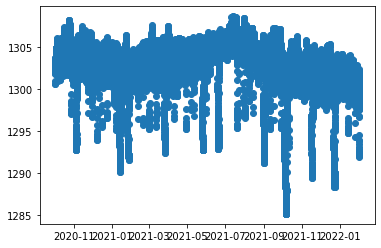

In [10]:
plt.scatter(y_pred.index, y_pred['temp_zuz'])
plt.show()

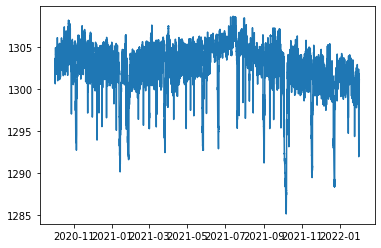

In [11]:
plt.plot(y_pred.index, y_pred['temp_zuz'])
plt.show()